<a href="https://colab.research.google.com/github/truong2710-cyber/Lab-WSN/blob/main/Q_Connectivity_sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ortools

     |████████████████████████████████| 14.4MB 187kB/s 
     |████████████████████████████████| 1.0MB 36.4MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
import matplotlib.pyplot as plt
import xlrd
import numpy as np
from ortools.linear_solver import pywraplp
from math import sqrt
import time
import pandas as pd
import copy
import secrets

class point:
    def __init__(self,x,y):
        self.x=x
        self.y=y

class vector:
    def __init__(self,x,y):
        self.x=x
        self.y=y


def distance(t1,t2):
    a=point(t1[0],t1[1])
    b=point(t2[0],t2[1])
    return sqrt((a.x-b.x)**2+(a.y-b.y)**2)

def intersection_point_2circle(t1,t2,r):
    a=point(t1[0],t1[1])
    b=point(t2[0],t2[1])
    if sqrt((a.x-b.x)**2+(a.y-b.y)**2)>2*r:
        return []
    m=point((a.x+b.x)/2,(a.y+b.y)/2)
    d=sqrt(r**2-((a.x-b.x)**2+(a.y-b.y)**2)/4)
    n1=d/sqrt((a.x-b.x)**2+(a.y-b.y)**2)
    n2=-n1
    i1=point((m.x+(a.y-b.y)*n1),(m.y+(b.x-a.x)*n1))
    i2=point((m.x+(a.y-b.y)*n2),(m.y+(b.x-a.x)*n2))
    return [[i1.x,i1.y],[i2.x,i2.y]]

def intersectionPoint(x,y,z,t,r):
    d=distance(x,y)
    a=vector(x[0]-y[0],x[1]-y[1])
    b=vector(z[0]-t[0],z[1]-t[1])
    x=point(x[0],x[1])
    z=point(z[0],z[1])
    if a.x*b.y-a.y*b.x!=0:
        t1=((z.x-x.x)*a.y-(z.y-x.y)*a.x)/(b.y*a.x-b.x*a.y)
        i=[(z.x+b.x*t1),(z.y+b.y*t1)]
        if a.x!=0:
            t=(z.x-x.x+b.x*t1)/a.x
        else:
            t=(z.y-x.y+b.y*t1)/a.y
        if distance(i,y)<=r and t>=-1 and d>r:
            return i
        else:
            return []
    else:
        return []
        
def intersectionPointCircle(o,p,r):
    t=r/distance(o,p)
    x=o[0]+(p[0]-o[0])*t
    y=o[1]+(p[1]-o[1])*t
    return [x,y]

def condition(x):
    return x[0]

def arrange(t,points):
    under=[x for x in points if x[1]<=t[1]]
    above=[x for x in points if x[1]>t[1]]
    under.sort(key=condition)
    above.sort(key=condition, reverse=True)
    points=above+under
    return points

def findIntersectionPoints(tList,t):
    points=[]
    for x in tList:
        if x!=t and distance(t,x)<2*r:
            points.extend(intersection_point_2circle(t,x,r))
    return points

def findIntersectionTargets(tList,point):
    intersection_targets=[]
    for t in tList:
        if distance(point,t)<=r+0.0005:
            intersection_targets.append(tList.index(t))
    return intersection_targets

def findArc(tList,t,p1,p2):
    target_set_1 = findIntersectionTargets(tList,p1) 
    target_set_2 = findIntersectionTargets(tList,p2)
    target_set_1=set(target_set_1)
    target_set_2=set(target_set_2)
    return list(target_set_1 & target_set_2)

def findCriticalRegion(tList,t):
    arc=[]
    points=findIntersectionPoints(tList,t)
    points=arrange(t,points)
    points.append(points[0])
    for x in range(len(points)-1):
        arc.append(findArc(tList,t,points[x],points[x+1]))
    return list(set(max(arc,key=len)))

def isSubset(x,region):
    for i in x:
        if i not in region:
            return False
    return True

def delete(regions):
    erase=[]
    for x in regions:
        for region in regions: 
            if x!=region and isSubset(x,region):
                erase.append(x)
    for x in erase:
        if x in regions:
            regions.remove(x)
    return regions
            
def findAllCriticalRegions(tList):
    regions=[]
    for t in tList:
        if len(findIntersectionPoints(tList,t))>0:
            if findCriticalRegion(tList,t) not in regions:
                regions.append(findCriticalRegion(tList,t))
        else:
            regions.append([tList.index(t)])
    regions=delete(regions)
    return regions
    
def solve(tList,regions,q):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    x=[[]]*len(regions)
    for i in range(len(regions)):
        x[i]=solver.IntVar(0,solver.infinity(),' ')
    for j in range(len(tList)):
        solver.Add(solver.Sum([x[i] for i in range(len(regions)) if j in regions[i]])>=q[j])
    M=solver.Sum(x)
    opjective=solver.Minimize(M)
    solver.Solve()
    #for i in range(len(regions)):
    #    print(int(x[i].solution_value()),end=' ')
    return [int(x[i].solution_value()) for i in range(len(regions))]

def minimalPoint(part,tList,r,p):
    check=True
    for x in part:
        if distance(p,tList[x])>r:
            check=False
    if check==True:
        return p
    if len(part)==1:
        if distance(p,tList[part[0]])>r:
            return intersectionPointCircle(tList[part[0]],p,r)
        else:
            return p
    c=findCommonPart(tList,part,r)
    for i in range(len(part)):
        if len(c[i])!=0:
            z=c[i][0]
            t=c[i][1]
            if z[0]!=t[0] or z[1]!=t[1]:
                if len(intersectionPoint(p,tList[part[i]],z,t,r))>0:
                    return intersectionPointCircle(tList[part[i]],p,r)
            elif intersectionPointCircle(tList[part[i]],p,r)==z and distance(tList[part[i]],p)>=r:
                return z
        
    for x in c:
        if len(x)!=0:
            m=x[0]
            break
    for l in c:
        for x in l:
            if distance(p,x)<=distance(p,m):
                m=x
    return m

def findCommonPart(tList,part,r):
    c=[]
    for i in part:
        l=[]
        erase=[]
        for j in part:
            if j!=i:
                l.extend(intersection_point_2circle(tList[i],tList[j],r))
        for x in l:
            check=True
            for j in part:
                if distance(x,tList[j])>r+0.0001:
                    check=False
                    break
            if check==False:
                erase.append(x)
        for x in erase:
            l.remove(x)
        c.append(l)
    return c
        

In [ ]:
def place_relay_nodes_between_2_sensors(s1,s2):
    k=int(distance(s1,s2)/Rc)
    unit_vector=vector((s2[0]-s1[0])/distance(s1,s2),(s2[1]-s1[1])/distance(s1,s2))
    for i in range(1,k+1):
        relay_nodes.append([s1[0]+unit_vector.x*k*Rc,s1[1]+unit_vector.y*k*Rc])

q: [2, 4, 7, 6, 4, 7, 2, 5, 3, 7]
q_sensor: [2, 4, 7, 6, 4, 7, 5, 7]
regions:  [[0, 6], [8, 1], [2], [3, 6], [4], [5], [7], [9]]
centers:  [0, 1, 2, 3, 4, 5, 6, 7]
Total sensors:  42
x:  [2, 4, 7, 6, 4, 7, 5, 7]
Place sensors at:  [[7.759580758006324, 5.3347117711293475], [54.05813797066158, 26.923255188264633], [82.08600991455516, 85.77526878711944], [19.360073817939263, 5.3407100187418655], [63.0, 0.0], [32.56705853752834, 29.310352683775502], [48.7698378014741, 79.47677271351334], [65.21719897266934, 70.65196555372512]]


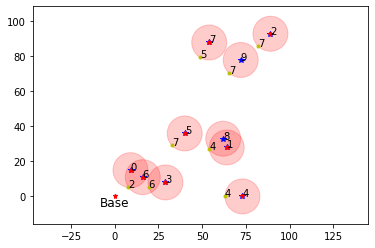

In [ ]:
np.random.seed(10)
relay_nodes=[]
Base=[0,0]
Area=100
n=10
r=10
Rc=20
tList=np.random.randint(0,Area,(n,2)).tolist()
q=np.random.randint(1,10,n).tolist()
regions=findAllCriticalRegions(tList)
x=solve(tList,regions,q)
points_to_place=[minimalPoint(regions[i],tList,r,Base) for i in range(len(x))]
q_sensor=[]
for region in regions:
    q_sensor.append(max([q[i] for i in region]))
  

if 0 in x:
    x.remove(0)
points_to_place=[points_to_place[i] for i in range(len(x)) if x[i]!=0]
q_sensor=[q_sensor[i] for i in range(len(x)) if x[i]!=0]
centers=[i for i in range(len(points_to_place))]
print('q:',q)
print('q_sensor:',q_sensor) 
print("regions: ",regions)
print("centers: ",centers)
print("Total sensors: ",sum(x))
print("x: ",x)
print("Place sensors at: ",points_to_place)


fig, ax = plt.subplots()
for i in range(len(tList)):
     ax.add_patch(plt.Circle((tList[i][0], tList[i][1]), r, color='r', alpha=0.2))
     plt.plot(tList[i][0],tList[i][1],'b*')
     plt.text(tList[i][0],tList[i][1],str(i))
for i in range(len(points_to_place)):
    plt.plot(points_to_place[i][0],points_to_place[i][1],'y.')
    plt.text(points_to_place[i][0],points_to_place[i][1],str(x[i]))
ax.set_aspect('equal', adjustable='datalim')
plt.plot(Base[0],Base[1],"r*",markersize=5)
plt.text(Base[0],Base[1],"Base",horizontalalignment="center",verticalalignment="top",fontsize=12)
for i in centers:
    plt.plot(tList[i][0],tList[i][1],"r*",markersize=5)
plt.show()

In [ ]:
def deg(i,adjacency_mat):
    return len(adjacency_mat[i])

def build_graph(centers,Base):
    points_to_place_ext=points_to_place.copy()
    points_to_place_ext.append(Base)
    max_q=max([q_sensor[i] for i in centers])
    q_sensor_ext=q_sensor.copy()
    q_sensor_ext.append(max_q)
    centers_ext=centers.copy()
    centers_ext.append(len(centers))
    k=len(centers_ext)
    #c=[[0 for i in range(k)] for j in range(k)]
    adjacency_list=[[] for i in range(k)]
    edges={}
    for i in range(k-1):
        for j in range(i+1,k):
            edges[(i,j)]=distance(points_to_place_ext[centers_ext[i]],points_to_place_ext[centers_ext[j]])
    sorted_tuples = sorted(edges.items(), key=lambda item: item[1])
    sorted_edges = {k: v for k, v in sorted_tuples}
    sorted_edges_copy=copy.deepcopy(sorted_edges)
    for edge in sorted_edges_copy.items():
        if deg(edge[0][0],adjacency_list)<q_sensor_ext[centers_ext[edge[0][0]]] or deg(edge[0][1],adjacency_list)<q_sensor_ext[centers_ext[edge[0][1]]]:
            adjacency_list[edge[0][0]].append(edge[0][1])
            adjacency_list[edge[0][1]].append(edge[0][0])
            sorted_edges.pop(edge[0])
    return adjacency_list,sorted_edges
adjacency_list,sorted_edges_left=build_graph(centers,Base)
print(sorted_edges_left)
print(adjacency_list)


{(0, 1): 51.084455628371416, (4, 6): 80.74066458205441, (0, 6): 84.72830922162603, (2, 8): 118.72451204024819}
[[8, 3, 5, 4, 7, 2], [5, 4, 3, 7, 6, 8, 2], [7, 6, 1, 5, 4, 3, 0], [0, 8, 5, 1, 4, 6, 7, 2], [1, 5, 3, 0, 8, 7, 2], [1, 3, 0, 4, 8, 7, 6, 2], [7, 2, 5, 1, 3, 8], [6, 2, 1, 5, 4, 3, 0, 8], [0, 3, 5, 1, 4, 6, 7]]


In [ ]:
def FindPath(V,f,s,t,c,n):
    # Find Augmentation Path
    
    p={i:'0' for i in V}
    p[s]=s
    epsi={i:9999 for i in V}
    VT=[s]
    check={i:0 for i in V}
    check[s]=1
    while len(VT)>0:
        u=VT.pop(0)
        for v in V:
            if check[v]==0:
                if c[u][v]>0 and f[u][v]<c[u][v]:
                    p[v]=u
                    epsi[v]=min(epsi[u],c[u][v]-f[u][v])
                    VT.append(v)
                    check[v]=1
                    
                if c[v][u]>0 and f[v][u]>0:
                    p[v]='-'+u
                    epsi[v]=min(epsi[u],f[v][u])
                    VT.append(v)
                    check[v]=1
    if check[t]==1:
        return (p,epsi)                
    return [False]

def IncFlow(V,f,s,t,c,n):
    # Increase Flow using Augmentation Path
    p,epsi=FindPath(V,f,s,t,c,n)
    u=p[t]
    v=t
    inc=epsi[t]
    while v!=s:
        if u.startswith("-")==False:
            f[u][v]+=inc
        else:
            u=u.replace('-','')
            f[v][u]-=inc
        v=u
        u=p[v]
def MaxFlow(s,t,c,n,V):
    """
    input: 
      s: source (string)
      t: target (string)
      c: adjacency matrix
      n: number of vertexes
      V: vertex list (string)
    output:
      max flow from s to t
    """
    
    f={i:{j:0 for j in V} for i in V} # flow
    stop=False
    while stop==False:
        if len(FindPath(V,f,s,t,c,n))>1:
            IncFlow(V,f,s,t,c,n)
        else:
            stop=True
    max_flow=0
    for u in V:
        max_flow+=f[s][u]
    return max_flow

In [ ]:
def check_q_connect(i,adjacency_list):
    k=len(adjacency_list)
    s=str(i)
    t=str(k-1)
    V=[s,t]
    for i in range(len(adjacency_list)-1):
        if str(i)!=s:
            V.extend([str(i)+"'",str(i)+"''"])
    N=len(V)
    c={i:{j:0 for j in V} for i in V}
    for u in range(k):
        for v in adjacency_list[u]:
            if str(u)!=s and str(u)!=t and str(v)!=s and str(v)!=t:
                c[str(u)+"'"][str(u)+"''"]=1
                c[str(v)+"'"][str(v)+"''"]=1
                c[str(u)+"''"][str(v)+"'"]=1
                c[str(v)+"''"][str(u)+"'"]=1
            elif str(u)==s and str(v)!=t:
                c[str(v)+"'"][str(v)+"''"]=1
                c[str(u)][str(v)+"'"]=1
            elif str(u)==s and str(v)==t:
                c[str(u)][str(v)]=1
            elif str(u)==t and str(v)!=s:
                c[str(v)+"'"][str(v)+"''"]=1
                c[str(v)+"''"][str(u)]=1
            elif str(u)==t and str(v)==s:
                c[str(v)][str(u)]=1
    max_flow=MaxFlow(s,t,c,N,V)
    return max_flow>=q_sensor[centers[i]]
for i in range(len(centers)):
    print(check_q_connect(i,adjacency_list))


False
True
True
True
True
True
False
True


In [ ]:
def insert_edge():
    centers_ext=centers.copy()
    centers_ext.append(len(centers))
    k=len(centers)
    for i in range(k-1):
        if check_q_connect(i,adjacency_list)==False:
                for insert_edge in sorted_edges_left:
                    if (i in insert_edge) and (insert_edge[1] not in adjacency_list[insert_edge[0]]):
                        adjacency_list[insert_edge[0]].append(insert_edge[1])
                        adjacency_list[insert_edge[1]].append(insert_edge[0])
                        #sorted_edges_left.pop(insert_edge)
                      
                    if check_q_connect(i,adjacency_list):
                        break
                  


In [ ]:
insert_edge()
print(adjacency_list)


[[8, 3, 5, 4, 7, 2, 1], [5, 4, 3, 7, 6, 8, 2, 0], [7, 6, 1, 5, 4, 3, 0], [0, 8, 5, 1, 4, 6, 7, 2], [1, 5, 3, 0, 8, 7, 2, 6], [1, 3, 0, 4, 8, 7, 6, 2], [7, 2, 5, 1, 3, 8, 4], [6, 2, 1, 5, 4, 3, 0, 8], [0, 3, 5, 1, 4, 6, 7]]


In [ ]:
for i in range(len(centers)):
    print(check_q_connect(i,adjacency_list))


True
True
True
True
True
True
True
True


In [ ]:
def place_relay_nodes_between_centers(adjacency_list):
    points_to_place_ext=points_to_place.copy()
    points_to_place_ext.append(Base)
    
    centers_ext=centers.copy()
    centers_ext.append(len(centers))
    for u in range(len(adjacency_list)):
        for v in adjacency_list[u]:
            if u<v:
                place_relay_nodes_between_2_sensors(points_to_place_ext[u],points_to_place_ext[v])

relay_nodes=[]

place_relay_nodes_between_centers(adjacency_list)
print("Number of relay nodes:",len(relay_nodes))
print("Location of relay nodes:",relay_nodes)
print(adjacency_list)

Number of relay nodes: 78
Location of relay nodes: [[22.140773748377555, 19.233678933249607], [47.5743499883175, 1.4896953684248366], [47.5743499883175, 1.4896953684248366], [60.59863488728118, 65.40162744626255], [60.59863488728118, 65.40162744626255], [60.59863488728118, 65.40162744626255], [60.59863488728118, 65.40162744626255], [75.62387061292398, 78.78155079424675], [75.62387061292398, 78.78155079424675], [75.62387061292398, 78.78155079424675], [75.62387061292398, 78.78155079424675], [75.62387061292398, 78.78155079424675], [44.01214067522846, 22.238909458337652], [44.01214067522846, 22.238909458337652], [34.18038205495999, 29.13115458719351], [60.36203291411513, 7.9427149287804255], [20.092641908629226, 5.796374745093086], [20.092641908629226, 5.796374745093086], [63.948711416162524, 65.68117769346544], [63.948711416162524, 65.68117769346544], [50.05328504532637, 66.72226463632043], [50.05328504532637, 66.72226463632043], [0.35052133748022385, 0.17457455569471847], [0.350521337480

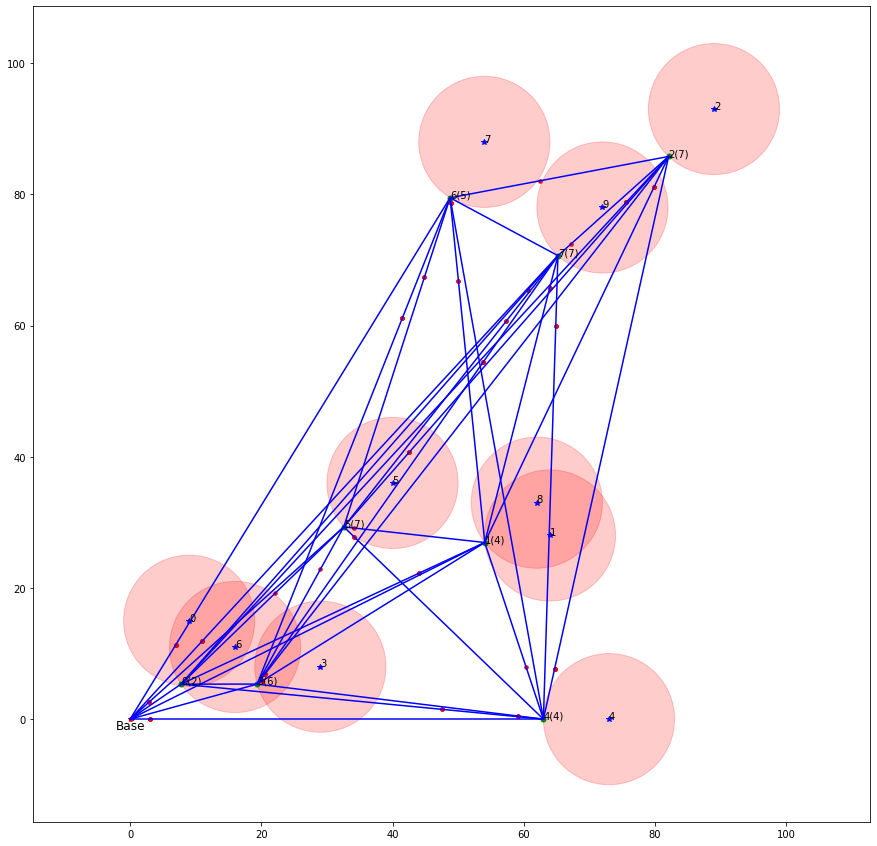

In [ ]:
points_to_place_ext=points_to_place.copy()
points_to_place_ext.append(Base)

fig, ax = plt.subplots(figsize=(15,15))

for i in range(len(tList)):
     ax.add_patch(plt.Circle((tList[i][0], tList[i][1]), r, color='r', alpha=0.2))
     plt.plot(tList[i][0],tList[i][1],'b*')
     plt.text(tList[i][0],tList[i][1],str(i))
for i in range(len(points_to_place)):
    plt.plot(points_to_place[i][0],points_to_place[i][1],'g.',markersize=10)
    plt.text(points_to_place[i][0],points_to_place[i][1],str(i)+"("+str(x[i])+")")
ax.set_aspect('equal', adjustable='datalim')
plt.plot(Base[0],Base[1],"r*",markersize=5)
plt.text(Base[0],Base[1],"Base",horizontalalignment="center",verticalalignment="top",fontsize=12)
for node in relay_nodes:
    plt.plot(node[0],node[1],"r.",markersize=7)
for u in range(len(adjacency_list)):
    for v in adjacency_list[u]:
        if u<v:
            plt.plot([points_to_place_ext[u][0],points_to_place_ext[v][0]],[points_to_place_ext[u][1],points_to_place_ext[v][1]],'b-')

plt.show()